In [1]:
import scipy.io
import pandas as pd

import matplotlib.pyplot as plt 
import pandas as pd

import sys

from utils import Laplace_smoothing, binary_reshuffling_indeces


I preprocess the data as described in the paper

## Loading already normalized and filtered data from Github

I download the data from github. They have already been normalized using Pearson's residuals and the 6 genes interesting for this study has been filtered out. The original data should represent counts.

In [2]:
#Loading the data form .txt file
X = pd.read_csv("../data/fromGitHub/expr_matrix_pearsonresidual_7.txt", delimiter="\t", index_col=0)
X

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X28199,X28200,X28201,X28202,X28203,X28204,X28205,X28206,X28207,X28208
genes,,,,,,,,,,,,,,,,,,,,,
AICDA,-0.744255,-0.574980,-0.756529,1.000327,-0.505078,0.304553,3.661197,-0.647302,-0.540428,-0.473138,...,-1.068594,-1.300649,1.616270,-1.148099,5.718382,-0.790627,0.059278,-1.357113,0.213631,-0.783982
IRF4,-1.389371,0.760179,0.670392,-1.152912,-0.946417,-0.982213,-1.283304,-0.396369,-0.034344,-0.886916,...,-1.980350,-1.213073,-0.893562,-2.123090,-1.676305,0.515546,-1.255932,-1.741480,0.085936,-0.793252
PAX5,0.869163,1.470277,5.327456,-0.541244,-0.443544,-0.751795,2.700289,-0.568548,-0.474607,-0.415480,...,-0.939362,-0.281450,-0.418613,-0.028920,1.927395,-0.694599,-0.849081,-0.368333,1.741314,-0.688753
PRDM1,-0.639366,-0.493802,-0.649925,-0.529274,-0.433726,0.617584,-0.589884,-0.555978,-0.464104,-0.406281,...,-0.918707,-1.119025,-0.409345,-0.987290,-0.988463,-0.679266,-0.830382,-1.167835,-0.769016,-0.673548
REL,0.499583,0.178566,1.276864,0.039775,-0.800315,0.102578,0.732897,1.873396,-0.856088,-0.749882,...,0.051197,-1.098703,-0.755514,3.019721,-1.271442,1.902585,-1.523056,-0.777008,0.669901,0.350704
RELA,-0.558294,-0.431103,1.188840,-0.462092,-0.378630,-0.642089,1.421361,-0.485423,-0.405163,-0.354662,...,0.435243,0.034475,-0.357337,0.287862,-0.863712,-0.593173,-0.725332,-1.020918,-0.671651,-0.588174


In [3]:
# Binarizing the data: 0 if negative or zero, 1 if positive
X[X>0]=1
X[~(X>0)]=0 #~ bitwise not: it applies not to each element of the vector
X = X.astype(int)
X


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X28199,X28200,X28201,X28202,X28203,X28204,X28205,X28206,X28207,X28208
genes,,,,,,,,,,,,,,,,,,,,,
AICDA,0,0,0,1,0,1,1,0,0,0,...,0,0,1,0,1,0,1,0,1,0
IRF4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
PAX5,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
PRDM1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
REL,1,1,1,1,0,1,1,1,0,0,...,1,0,0,1,0,1,0,0,1,1
RELA,0,0,1,0,0,0,1,0,0,0,...,1,1,0,1,0,0,0,0,0,0


In [4]:
# Calculating the activity ratios, i.e. the fraction of cells that are found to express each gene
total_cells = X.shape[1]
print(total_cells)
X['act_ratios'] = (X == 1).sum(axis=1) / total_cells
X = X.sort_values(by='act_ratios', ascending=False)
X

28208


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X28200,X28201,X28202,X28203,X28204,X28205,X28206,X28207,X28208,act_ratios
genes,,,,,,,,,,,,,,,,,,,,,
IRF4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0.348908
REL,1,1,1,1,0,1,1,1,0,0,...,0,0,1,0,1,0,0,1,1,0.345434
PAX5,1,1,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0.330474
RELA,0,0,1,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0.311401
PRDM1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.272121
AICDA,0,0,0,1,0,1,1,0,0,0,...,0,1,0,1,0,1,0,1,0,0.206963


In [6]:
# Labelling the columns with the reverse of the gene sequence (it identifies the expressed genes for each cell using 1es and zeros)
new_labels = []
for column_name, column_data in X.items():
    if column_name != 'act_ratios':
        new_labels.append(''.join( [str(i) for i in reversed(column_data)] ))
    else:
        new_labels.append(column_name)
X.columns = new_labels
X

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11236\3644073168.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_labels.append(''.join( [str(i) for i in reversed(column_data)] ))


,000110,000111,001111,100010,000000,110010,101110,000010,000000,000000,...,001000,100000,001010,100100,000011,100000,000000,100111,000010,act_ratios
genes,,,,,,,,,,,,,,,,,,,,,
IRF4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0.348908
REL,1,1,1,1,0,1,1,1,0,0,...,0,0,1,0,1,0,0,1,1,0.345434
PAX5,1,1,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0.330474
RELA,0,0,1,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0.311401
PRDM1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.272121
AICDA,0,0,0,1,0,1,1,0,0,0,...,0,1,0,1,0,1,0,1,0,0.206963


In [8]:
# Discarding cells whose colums are all zeros: 
# only cells with expression values for at least one of gene are informative. 
X = X.loc[:, (X != 0).any(axis=0)]
X

,000110,000111,001111,100010,110010,101110,000010,000001,001110,110000,...,001010,001000,100000,001010,100100,000011,100000,100111,000010,act_ratios
genes,,,,,,,,,,,,,,,,,,,,,
IRF4,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0.348908
REL,1,1,1,1,1,1,1,0,1,0,...,1,0,0,1,0,1,0,1,1,0.345434
PAX5,1,1,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0.330474
RELA,0,0,1,0,0,1,0,0,1,0,...,1,1,0,1,0,0,0,0,0,0.311401
PRDM1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.272121
AICDA,0,0,0,1,1,1,0,0,0,1,...,0,0,1,0,1,0,1,1,0,0.206963


In [16]:
#Saving the act ratios to be used in the quantum circuit as initial angles of rotation of the qubitss
X['act_ratios'].to_csv('../results/act_ratios.csv', header=False)

In [10]:
# Computing the counts for each gene sequence: how any cells are characterized by that specific sequence
sequences_frequency = X.columns[:-1].value_counts()
sequences_probability = sequences_frequency / sequences_frequency.sum() #normalization
print(sequences_frequency.sum())

24828


In [15]:
# Computing and saving the smoothed pdf
sequences_probability_smooth = Laplace_smoothing(distribution=sequences_probability, N_trials=int(sequences_frequency.sum()), filename='../results/p_obs_smoothed')

[CHECKPOINT] Smoothed pdf values saved to ../results/p_obs_smoothed.


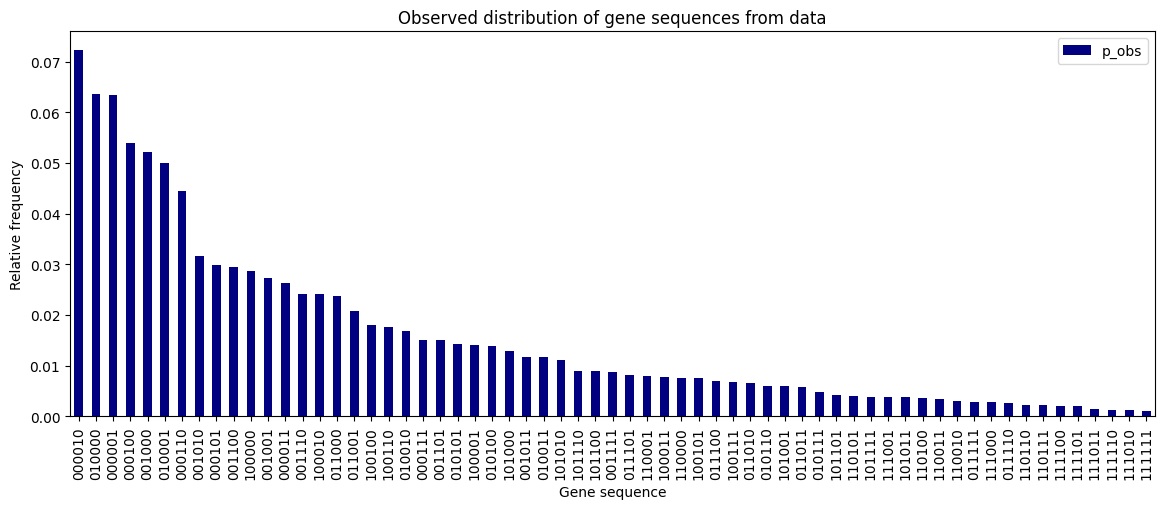

In [12]:
# Plotting the distribution of the counts

plt.figure(figsize=(14, 5))
sequences_probability.plot(kind='bar', label='p_obs', color='navy')
plt.legend()
plt.xlabel('Gene sequence')
plt.ylabel('Relative frequency')
plt.title('Observed distribution of gene sequences from data')
plt.show()

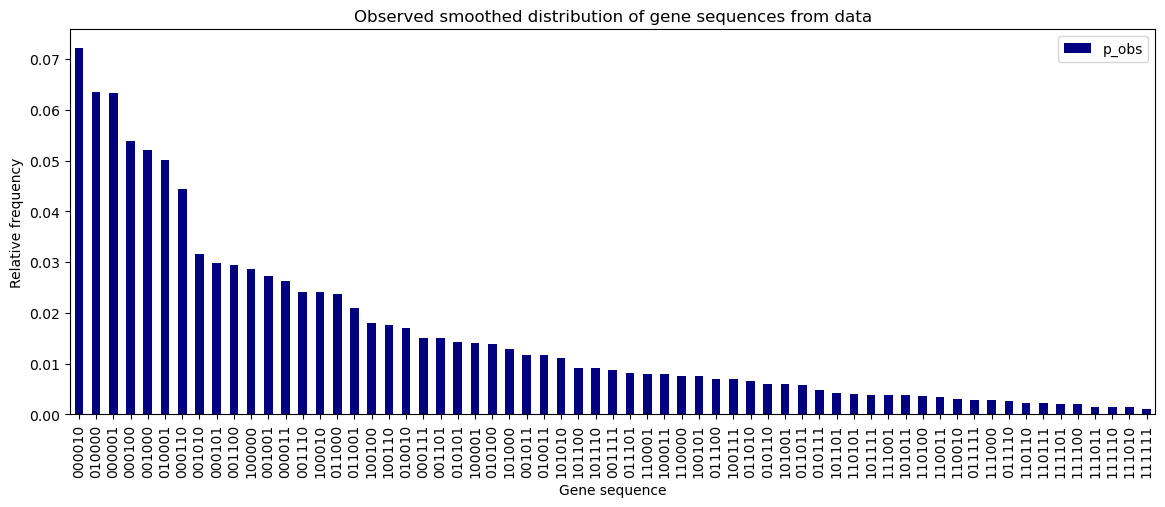

In [12]:
# Plotting the distribution of the counts

plt.figure(figsize=(14, 5))
sequences_probability_smooth.plot(kind='bar', label='p_obs', color='navy')
plt.legend()
plt.xlabel('Gene sequence')
plt.ylabel('Relative frequency')
plt.title('Observed smoothed distribution of gene sequences from data')
plt.show()

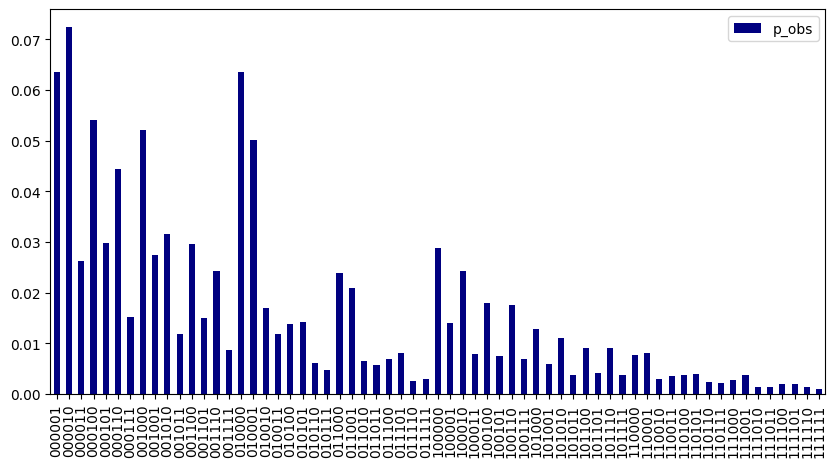

In [13]:
# Sorting the gene sequences as in the paper: in ascending order of the binary representation of the gene sequence
sequences_probability1 = binary_reshuffling_indeces(sequences_probability)

plt.figure(figsize=(10, 5))
sequences_probability1.plot(kind='bar', label='p_obs', color='navy')
plt.legend()
plt.show()